#Conditional Generative Adversarial Network  (cGAN)

Модель использует Conditional GAN для генерации изображений логотипов на основе текстовых меток. Предобработка данных включает изменение размера, нормализацию и преобразование текстовых меток в числовые индексы. Архитектура модели включает встраивание текста, генератор и дискриминатор. Тренировочный процесс оптимизирует обе модели с использованием функции потерь BCELoss.

**Общая структура**

##1. Модель

1.1. TextEmbedding

Этот модуль преобразует текстовые метки в векторные представления фиксированной длины:

* Вход: индекс текстовой метки.
* Выход: векторное представление размерности embedding_dim (в данном случае 128).
* Это стандартный подход для работы с категориальными данными, где каждая метка представляет собой уникальный класс.

```
class TextEmbedding(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(TextEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

    def forward(self, text):
        return self.embedding(text)
```

1.2. Generator

Генератор создает изображения на основе случайного шума (z) и текстового встраивания:

- Вход:
 - z: случайный шум размерности (batch_size, z_dim).
 - text_embedding: векторное представление текста размерности (batch_size, text_embedding_dim).
- Обработка:
 - Шум и текстовое встраивание объединяются в один тензор.
 - Применяется серия сверточных транспонированных слоев (ConvTranspose2d) для увеличения разрешения изображения.
- Выход: изображение размером (batch_size, 3, 32, 32).

```
class Generator(nn.Module):
    def __init__(self, z_dim=100, text_embedding_dim=128, output_channels=3):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(z_dim + text_embedding_dim, 256, kernel_size=4, stride=1, padding=0),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            ...
        )

    def forward(self, z, text_embedding):
        z = z.view(z.size(0), z.size(1), 1, 1)
        text_embedding = text_embedding.view(text_embedding.size(0), text_embedding.size(1), 1, 1)
        combined = torch.cat([z, text_embedding], dim=1)
        return self.model(combined)
```

1.3. Discriminator

Дискриминатор оценивает реалистичность изображения с учетом текстового встраивания:

- Вход:
 - Изображение размером (batch_size, 3, 32, 32).
 - Текстовое встраивание размером (batch_size, text_embedding_dim).
- Обработка:
 - Изображение обрабатывается через сверточные слои для извлечения признаков.
 - Текстовое встраивание преобразуется в вектор того же пространственного размера, что и признаки изображения.
 - Объединенные признаки передаются через финальный сверточный слой для получения вероятности реалистичности.
- Выход: скалярное значение (вероятность).

```
class Discriminator(nn.Module):
    def __init__(self, input_channels=3, text_embedding_dim=128):
        super(Discriminator, self).__init__()
        self.image_model = nn.Sequential(
            nn.Conv2d(input_channels, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            ...
        )
        self.text_model = nn.Sequential(
            nn.Linear(text_embedding_dim, 256),
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.final_layer = nn.Sequential(
            nn.Conv2d(256 + 256, 1, kernel_size=4, stride=1, padding=0),
            nn.Sigmoid()
        )

    def forward(self, x, text_embedding):
        image_features = self.image_model(x)
        text_features = self.text_model(text_embedding)
        text_features = text_features.view(text_features.size(0), text_features.size(1), 1, 1)
        text_features = text_features.repeat(1, 1, image_features.size(2), image_features.size(3))
        combined = torch.cat([image_features, text_features], dim=1)
        return self.final_layer(combined).view(-1)
```

## 2. Методы предобработки данных

2.1. Загрузка данных

Используется набор данных iamkaikai/amazing_logos_v4, который содержит изображения логотипов и соответствующие текстовые метки. Для удобства работы создается пользовательский класс LogoDataset.

```
class LogoDataset(Dataset):
    def __init__(self, hf_dataset, transform=None):
        self.dataset = hf_dataset
        self.transform = transform
        self.classes = sorted(list(set(self.dataset['text'])))
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}

    def __getitem__(self, idx):
        item = self.dataset[idx]
        image = item['image']
        text = item['text']
        label = self.class_to_idx[text]

        if not isinstance(image, Image.Image):
            image = Image.fromarray(image)

        if image.mode != 'RGB':
            image = image.convert('RGB')

        if self.transform:
            image = self.transform(image)

        text_index = text_to_index[text]

        return image, text_index
  ```

- Преобразования изображений:
 - Изменение размера до (32, 32).
 - Нормализация значений пикселей к диапазону [-1, 1]

```
transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
```

2.2. Текстовые метки

Текстовые метки преобразуются в числовые индексы с помощью словаря text_to_index. Это позволяет использовать их как входные данные для модели.

## 3. Тренировочный процесс


3.1. Цикл обучения

- Дискриминатор:
 - Оценивает реальные изображения и метки как "реальные" (метка 1).
 - Оценивает сгенерированные изображения как "фальшивые" (метка 0).
 - Суммарная функция потерь:

```
loss_discriminator = loss_real + loss_fake
```
- Генератор:
 - Пытается обмануть дискриминатор, заставляя его считать сгенерированные изображения "реальными".
 - Функция потерь:

 ```
loss_generator = criterion(output_generator, real_labels)
```

3.2. Сохранение контрольных точек
Каждую эпоху сохраняются:

- Генератор и дискриминатор.
- Оптимизаторы.
- Сгенерированные образцы для визуальной оценки.


##4. Заключение

4.1. Сильные стороны модели

- Использование текстовых меток делает модель условной, что повышает качество генерации.

- Архитектура генератора и дискриминатора хорошо подходит для задачи генерации изображений небольшого размера.

4.2. Недостатки

- Размер изображений ограничен (32, 32), что может быть недостаточно для сложных логотипов.

- Необходимость больших объемов данных для обучения.

#Реализация

Шаг 1: Установка необходимых библиотек

In [1]:
!pip install datasets torch torchvision pillow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.4/487.4 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 48.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 51.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 38.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 74.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Шаг 2: Импорт библиотек

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from datasets import load_dataset
from PIL import Image
import os
import torchvision

Шаг 3: Конфигурация устройства

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


Шаг 4: Загрузка данных

In [5]:
dataset = load_dataset("iamkaikai/amazing_logos_v4", split="train")

text_to_index = {text: idx for idx, text in enumerate(set(dataset['text']))}
index_to_text = {idx: text for text, idx in text_to_index.items()}

README.md:   0%|          | 0.00/408 [00:00<?, ?B/s]

(…)-00000-of-00014-8fa0be170a1cb1f2.parquet:   0%|          | 0.00/795M [00:00<?, ?B/s]

(…)-00001-of-00014-37a1302a48bbd86d.parquet:   0%|          | 0.00/1.04G [00:00<?, ?B/s]

(…)-00002-of-00014-2a126a6df42736cb.parquet:   0%|          | 0.00/1.04G [00:00<?, ?B/s]

(…)-00003-of-00014-8d6bea2f0d5bd27d.parquet:   0%|          | 0.00/1.03G [00:00<?, ?B/s]

(…)-00004-of-00014-218e3e1fc5250b20.parquet:   0%|          | 0.00/1.04G [00:00<?, ?B/s]

(…)-00005-of-00014-966998870845f350.parquet:   0%|          | 0.00/1.04G [00:00<?, ?B/s]

(…)-00006-of-00014-4248ed2e48521f4d.parquet:   0%|          | 0.00/1.02G [00:00<?, ?B/s]

(…)-00007-of-00014-22c6e1808f69eda9.parquet:   0%|          | 0.00/1.03G [00:00<?, ?B/s]

(…)-00008-of-00014-e1df3f6f9eb08fc5.parquet:   0%|          | 0.00/1.03G [00:00<?, ?B/s]

(…)-00009-of-00014-7b271b93a008ccc3.parquet:   0%|          | 0.00/1.03G [00:00<?, ?B/s]

(…)-00010-of-00014-a08c4775a1a9c068.parquet:   0%|          | 0.00/1.04G [00:00<?, ?B/s]

(…)-00011-of-00014-dee0a4db1e06bd69.parquet:   0%|          | 0.00/1.03G [00:00<?, ?B/s]

(…)-00012-of-00014-00457bc96a8beb8c.parquet:   0%|          | 0.00/1.03G [00:00<?, ?B/s]

(…)-00013-of-00014-e2a2aefd0807aab0.parquet:   0%|          | 0.00/1.03G [00:00<?, ?B/s]

Generating train split:   0%|          | 0/397251 [00:00<?, ? examples/s]

Loading dataset shards:   0%|          | 0/29 [00:00<?, ?it/s]

Шаг 5: Создание пользовательского класса Dataset

In [6]:
class LogoDataset(Dataset):
    def __init__(self, hf_dataset, transform=None):
        self.dataset = hf_dataset
        self.transform = transform
        self.classes = sorted(list(set(self.dataset['text'])))
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        image = item['image']
        text = item['text']
        label = self.class_to_idx[text]

        if not isinstance(image, Image.Image):
            image = Image.fromarray(image)

        if image.mode != 'RGB':
            image = image.convert('RGB')

        if self.transform:
            image = self.transform(image)

        text_index = text_to_index[text]

        return image, text_index

Шаг 6: Определение преобразований

In [7]:
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

Шаг 7: Создание DataLoader

In [8]:
logo_dataset = LogoDataset(dataset, transform=transform)
dataloader = DataLoader(logo_dataset, batch_size=64, shuffle=True)

Шаг 8: Определение моделей

In [9]:
# Модуль для встраивания текста
class TextEmbedding(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(TextEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

    def forward(self, text):
        return self.embedding(text)

# Генератор
class Generator(nn.Module):
    def __init__(self, z_dim=100, text_embedding_dim=128, output_channels=3):
        super(Generator, self).__init__()
        self.text_embedding_dim = text_embedding_dim
        self.model = nn.Sequential(
            nn.ConvTranspose2d(z_dim + text_embedding_dim, 256, kernel_size=4, stride=1, padding=0),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, output_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, z, text_embedding):
        z = z.view(z.size(0), z.size(1), 1, 1)
        text_embedding = text_embedding.view(text_embedding.size(0), text_embedding.size(1), 1, 1)
        combined = torch.cat([z, text_embedding], dim=1)
        return self.model(combined)

# Дискриминатор
class Discriminator(nn.Module):
    def __init__(self, input_channels=3, text_embedding_dim=128):
        super(Discriminator, self).__init__()
        self.text_embedding_dim = text_embedding_dim
        self.image_model = nn.Sequential(
            nn.Conv2d(input_channels, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.text_model = nn.Sequential(
            nn.Linear(text_embedding_dim, 256),
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.final_layer = nn.Sequential(
            nn.Conv2d(256 + 256, 1, kernel_size=4, stride=1, padding=0),
            nn.Sigmoid()
        )

    def forward(self, x, text_embedding):
        image_features = self.image_model(x)
        text_features = self.text_model(text_embedding)
        text_features = text_features.view(text_features.size(0), text_features.size(1), 1, 1)
        text_features = text_features.repeat(1, 1, image_features.size(2), image_features.size(3))
        combined = torch.cat([image_features, text_features], dim=1)
        return self.final_layer(combined).view(-1)

Шаг 9: Инициализация моделей и оптимизаторов

In [10]:
# Инициализация моделей
vocab_size = len(text_to_index)
text_embedding = TextEmbedding(vocab_size=vocab_size, embedding_dim=128).to(device)
generator = Generator(z_dim=100, text_embedding_dim=128).to(device)
discriminator = Discriminator(text_embedding_dim=128).to(device)

# Инициализация весов
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

generator.apply(weights_init)
discriminator.apply(weights_init)

# Оптимизаторы и функция потерь
lr = 0.0002
optimizerG = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizerD = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
criterion = nn.BCELoss()

# Параметры тренировки
num_epochs = 1
fixed_noise = torch.randn(64, 100, device=device)
fixed_text = torch.randint(0, vocab_size, (64,), device=device)

# Создание выходных каталогов
os.makedirs("output/samples_training", exist_ok=True)
os.makedirs("output/checkpoints", exist_ok=True)

Шаг 10: Тренировочный цикл

In [ ]:
# Тренировочный цикл
for epoch in range(num_epochs):
    for i, (real_images, text_labels) in enumerate(dataloader):
        real_images = real_images.to(device)
        text_labels = text_labels.to(device)
        batch_size = real_images.size(0)
        real_labels = torch.ones(batch_size, device=device)
        fake_labels = torch.zeros(batch_size, device=device)

        text_embeddings = text_embedding(text_labels)

        # Обучение дискриминатора
        discriminator.zero_grad()
        output_real = discriminator(real_images, text_embeddings)
        loss_real = criterion(output_real, real_labels)

        noise = torch.randn(batch_size, 100, device=device)
        fake_images = generator(noise, text_embeddings)
        output_fake = discriminator(fake_images.detach(), text_embeddings)
        loss_fake = criterion(output_fake, fake_labels)

        loss_discriminator = loss_real + loss_fake
        loss_discriminator.backward(retain_graph=True)
        optimizerD.step()

        # Обучение генератора
        generator.zero_grad()
        output_generator = discriminator(fake_images, text_embeddings)
        loss_generator = criterion(output_generator, real_labels)

        loss_generator.backward()
        optimizerG.step()

        # Вывод прогресса
        if i % 100 == 0:
            print(f"[Epoch {epoch}/{num_epochs}] [Batch {i}/{len(dataloader)}] "
                  f"Loss D: {loss_discriminator.item():.4f}, Loss G: {loss_generator.item():.4f}")

    # Сохранение сгенерированных образцов
    with torch.no_grad():
        fixed_text_embeddings = text_embedding(fixed_text)
        fake_images = generator(fixed_noise, fixed_text_embeddings).detach().cpu()
        grid = torchvision.utils.make_grid(fake_images, nrow=8, normalize=True)
        torchvision.utils.save_image(grid, f"output/samples_training/fake_epoch_{epoch}.png")

    # Сохранение контрольных точек модели
    torch.save({
        'epoch': epoch,
        'generator_state_dict': generator.state_dict(),
        'discriminator_state_dict': discriminator.state_dict(),
        'optimizerG_state_dict': optimizerG.state_dict(),
        'optimizerD_state_dict': optimizerD.state_dict()
    }, f"output/checkpoints/model_epoch_{epoch}.pth")

print("Training complete.")

[Epoch 0/1] [Batch 0/6208] Loss D: 1.9912, Loss G: 2.8777
[Epoch 0/1] [Batch 100/6208] Loss D: 0.0287, Loss G: 4.7820


#Эпоха №50

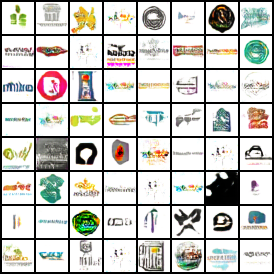